## Notebook Setup 
The following cell will install Drake, checkout the underactuated repository, and set up the path (only if necessary).
- On Google's Colaboratory, this **will take approximately two minutes** on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  Colab will ask you to "Reset all runtimes"; say no to save yourself the reinstall.
- On Binder, the machines should already be provisioned by the time you can run this; it should return (almost) instantly.

More details are available [here](http://underactuated.mit.edu/drake.html).

In [7]:
try:
  import pydrake
  import underactuated
except ImportError:
  !curl -s https://raw.githubusercontent.com/RussTedrake/underactuated/master/scripts/setup/jupyter_setup.py > jupyter_setup.py
  from jupyter_setup import setup_underactuated
  setup_underactuated()

# The Rimless Wheel

In [8]:
import numpy as np
from IPython import get_ipython

from underactuated.jupyter import AdvanceToAndVisualize, SetupMatplotlibBackend
plt_is_interactive = SetupMatplotlibBackend()

from pydrake.all import (DiagramBuilder, PlanarSceneGraphVisualizer, SceneGraph,
                         Simulator)
from pydrake.examples.rimless_wheel import (RimlessWheel, RimlessWheelGeometry,
                                            RimlessWheelParams)

def simulate(slope=0.08, initial_angle=0, initial_angular_velocity=5.0):
  params = RimlessWheelParams()
  params.set_slope(slope)

  builder = DiagramBuilder()
  rimless_wheel = builder.AddSystem(RimlessWheel())
  scene_graph = builder.AddSystem(SceneGraph())
  RimlessWheelGeometry.AddToBuilder(
      builder, rimless_wheel.get_floating_base_state_output_port(), params,
      scene_graph)
  visualizer = builder.AddSystem(
      PlanarSceneGraphVisualizer(scene_graph, xlim=[-8., 8.], ylim=[-2., 3.],
                                 show=plt_is_interactive))
  builder.Connect(scene_graph.get_pose_bundle_output_port(),
                  visualizer.get_input_port(0))

  diagram = builder.Build()
  simulator = Simulator(diagram)

  context = simulator.get_mutable_context()

  diagram.GetMutableSubsystemContext(
      rimless_wheel, context).get_numeric_parameter(0).set_slope(slope)
  context.SetAccuracy(1e-4)
  context.SetContinuousState([initial_angle, initial_angular_velocity])
  simulator.Initialize()
  
  duration = 5.0 if get_ipython() else 0.1 # sets a shorter duration during testing
  AdvanceToAndVisualize(simulator, visualizer, duration)

<IPython.core.display.Javascript object>


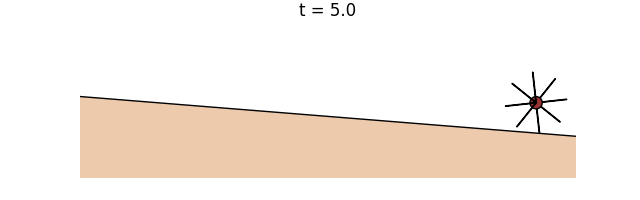

In [9]:
simulate()

<IPython.core.display.Javascript object>


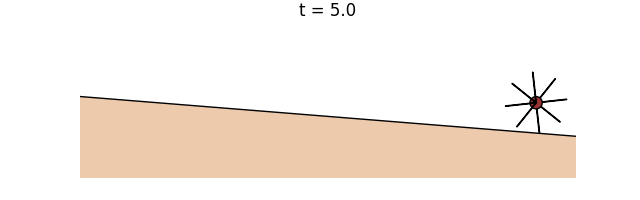

In [5]:
simulate(initial_angular_velocity=5.0)

In [ ]:
simulate(initial_angular_velocity=10.0)

In [ ]:
simulate(initial_angular_velocity=0.95)

In [ ]:
simulate(initial_angular_velocity=-5.0)

In [ ]:
simulate(initial_angular_velocity=-4.8)

Here is a little interactive plot to allow you to visualize the trajectories of the rimless wheel as you vary the initial velocity.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

from underactuated.jupyter import SetupMatplotlibBackend
plt_is_interactive = SetupMatplotlibBackend()

from pydrake.all import Simulator
from pydrake.examples.rimless_wheel import RimlessWheel

rimless_wheel = RimlessWheel()
simulator = Simulator(rimless_wheel)
context = simulator.get_mutable_context()
params = context.get_numeric_parameter(0)
qmin = params.slope() - rimless_wheel.calc_alpha(params) - 0.1
qmax = params.slope() + rimless_wheel.calc_alpha(params) + 0.1
qdmin = -2
qdmax = 2

context.SetAccuracy(1e-2)
integrator = simulator.get_mutable_integrator()

fig, ax = plt.subplots()

# TODO(russt): make the slope interactive, too.
def simulate(initial_angular_velocity=1.5, duration=1.5):
    rimless_wheel.SetDefaultContext(context)
    context.SetTime(0.0)
    if initial_angular_velocity >= 0:
        initial_angle = params.slope() - rimless_wheel.calc_alpha(params)
    else:
        initial_angle = params.slope() + rimless_wheel.calc_alpha(params)
    if initial_angular_velocity == 0:
        # Set double_support = True.
        context.get_mutable_abstract_state(0).set_value(True)
        
    context.SetContinuousState([initial_angle, initial_angular_velocity])

    integrator.StartDenseIntegration()
    simulator.AdvanceTo(duration)
    pp = integrator.StopDenseIntegration()

    return pp.vector_values(pp.get_segment_times())

if plt_is_interactive:
    data = simulate()
    line, = ax.plot(data[0,:], data[1,:],'b')
    pt, = ax.plot(data[0,0], data[1,0],'b*', markersize=12)
    
    def update(initial_angular_velocity):
        data = simulate(initial_angular_velocity)
        line.set_xdata(data[0,:])
        line.set_ydata(data[1,:])
        pt.set_xdata(data[0,0])
        pt.set_ydata(data[1,0])
        fig.canvas.draw()
    
    interact(update, initial_angular_velocity=widgets.FloatSlider(min=qdmin, max=qdmax, step=.1, value=1.1))

else:
    data = simulate()
    ax.plot(data[0,:], data[1,:],'b')
    ax.plot(data[0,0], data[1,0],'b*', markersize=12)

# Plot the energy contours.
nq = 151
nqd = 151
mgl = params.mass() * params.gravity() * params.length()
q = np.linspace(qmin, qmax, nq)
qd = np.linspace(qdmin, qdmax, nqd)
Q, QD = np.meshgrid(q, qd)
Energy = .5 * params.mass() * params.length()**2 * QD**2 + mgl * np.cos(Q)
ax.contour(Q,
           QD,
           Energy,
           alpha=0.5,
           linestyles="dashed",
           colors="black",
           linewidths=0.5)

ax.plot(params.slope() - rimless_wheel.calc_alpha(params)*np.array([1, 1]), np.array([0, qdmax]), 'k--')
ax.plot(params.slope() - rimless_wheel.calc_alpha(params)*np.array([1, 1]), np.array([0, qdmin]), 'k', linewidth=.25)
ax.plot(params.slope() + rimless_wheel.calc_alpha(params)*np.array([1, 1]), np.array([0, qdmin]), 'k--')
ax.plot(params.slope() + rimless_wheel.calc_alpha(params)*np.array([1, 1]), np.array([0, qdmax]), 'k', linewidth=.25)
ax.plot([qmin, qmax], [0, 0], 'k', linewidth=.25)
ax.plot([0, 0], [qdmin, qdmax], 'k', linewidth=.25)
ax.set_xlabel("theta")
ax.set_ylabel("thetadot")
ax.axis([qmin, qmax, qdmin, qdmax])
ax.set_title("Trajectories of the Rimless Wheel (w/ contours of "
             "constant energy)");

# The Compass Gait

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import get_ipython

from underactuated.jupyter import AdvanceToAndVisualize, SetupMatplotlibBackend
plt_is_interactive = SetupMatplotlibBackend()

from pydrake.all import (ConstantVectorSource, DiagramBuilder,
                         PlanarSceneGraphVisualizer, SceneGraph, SignalLogger,
                         Simulator)
from pydrake.examples.compass_gait import (CompassGait, CompassGaitGeometry,
                                           CompassGaitParams)

builder = DiagramBuilder()
compass_gait = builder.AddSystem(CompassGait())

hip_torque = builder.AddSystem(ConstantVectorSource([0.0]))
builder.Connect(hip_torque.get_output_port(0), compass_gait.get_input_port(0))

scene_graph = builder.AddSystem(SceneGraph())
CompassGaitGeometry.AddToBuilder(
    builder, compass_gait.get_floating_base_state_output_port(), scene_graph)
visualizer = builder.AddSystem(
    PlanarSceneGraphVisualizer(scene_graph, xlim=[-1., 5.], ylim=[-1., 2.], 
                               show=plt_is_interactive))
builder.Connect(scene_graph.get_pose_bundle_output_port(),
                visualizer.get_input_port(0))

logger = builder.AddSystem(SignalLogger(14))
builder.Connect(compass_gait.get_output_port(1), logger.get_input_port(0))

diagram = builder.Build()
simulator = Simulator(diagram)

context = simulator.get_mutable_context()
context.SetAccuracy(1e-4)
context.SetContinuousState([0., 0., 0.4, -2.])

duration = 8.0 if get_ipython() else 0.1 # sets a shorter duration during testing
AdvanceToAndVisualize(simulator, visualizer, duration)

In [ ]:
plt.figure()
plt.plot(logger.data()[4, :], logger.data()[11, :])
plt.xlabel("left leg angle")
plt.ylabel("left leg angular velocity");